# Analysis of how causal model build states

In [1]:
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import paired_distances

from incstates import IncStatesAnalyser
from utils import detect_added_positions, METRIC


/tmp/ipykernel_2096635/1915458715.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/users/blasota/anaconda3/envs/restart-inc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = './outputs/preprocessed_stimuli.csv'

SOURCE =  'classic-mvrr' #'classic-nps'

MODEL = 'opt'
N_LAYERS = 13
N = 10

STATES_PATH = './outputs/embeddings/'
TRIANGLES_PATH = './outputs/triangles/'

COLS = cols = ['noun 1', 'verb 1', 'det', 'noun 2', 'verb 2', 't1', 't2', 't3', 't4', 't5']

In [3]:
def dist_func(*x):
    """Return a specific distance function between two vectors."""
    return paired_distances(*x, metric=METRIC) 


def get_objects(df, prisms):

    objs = {}
    for idx, row in df.iterrows():
        if f'{idx}_baseline' not in prisms:
            continue
        objs[idx] = {}

        stimulus, baseline = row.stimulus, row.baseline
        # we will remove the tokens added to disambiguate in advance
        additions = detect_added_positions(stimulus.split(), baseline.split())

        stimulus_states = prisms[f'{idx}_stimulus']
        obj_stimulus = IncStatesAnalyser(stimulus,
                                         states=stimulus_states,
                                         tokenized=True)
        objs[idx]['stimulus'] = obj_stimulus

        baseline_sent_states = prisms[f'{idx}_baseline']
        obj_baseline = IncStatesAnalyser(baseline,
                                         states=baseline_sent_states,
                                         additions=additions,
                                         tokenized=True)
        objs[idx]['baseline'] = obj_baseline

    return objs


def get_diagonal_distances(prisms, objs, df):

    aligneds = {layer: {} for layer in range(N_LAYERS)}

    for idx, row in df.iterrows():
        if f'{idx}_baseline' not in prisms:
            continue
        for layer in range(N_LAYERS):

            state_stimulus = objs[idx]['stimulus'].get_layer_state(layer)
            state_baseline = objs[idx]['baseline'].get_layer_state(layer, remove_additions=True)

            diag_stimulus = state_stimulus.diagonal(axis1=0, axis2=1).T
            diag_baseline = state_baseline.diagonal(axis1=0, axis2=1).T
            diag_dists = dist_func(diag_baseline, diag_stimulus)

            # start from the first noun + N tokens
            begin = int(df.loc[idx].amb_position_ambiguous) - 1
            aligned_diag_dists = diag_dists[begin: begin + N]
            aligneds[layer][row.orig_idx] = aligned_diag_dists
    
    return aligneds

In [4]:
data_df = pd.read_csv(DATA_PATH, index_col=0)

Compute the cosine distance from the stimulus to the baseline and from the "neutral" stimulus to the "neutral" baseline:

In [5]:
df = data_df[data_df.source==SOURCE]

with h5py.File(Path(f'{STATES_PATH}{MODEL}_{SOURCE}_embeddings.h5'), 'r') as f:
    prisms = {key: value[:] for key, value in f.items()}

objs = get_objects(df, prisms)
aligneds = get_diagonal_distances(prisms, objs, df)


df_ref = data_df[data_df.source==SOURCE + '_for-causal']

with h5py.File(Path(f'{STATES_PATH}{MODEL}_{SOURCE}_for-causal_embeddings.h5'), 'r') as f:
    prisms_ref = {key: value[:] for key, value in f.items()}

objs_ref = get_objects(df_ref, prisms_ref)
aligneds_ref = get_diagonal_distances(prisms_ref, objs_ref, df_ref)

assert (df.orig_idx.values == df_ref.orig_idx.values).all()
assert len(df.orig_idx.unique()) == len(df.orig_idx)

Take the absolute difference between the real pair and the "neutral" pair:

In [6]:
diffs = {layer: [] for layer in range(N_LAYERS)}

for layer in range(N_LAYERS):
    for idx in df.orig_idx:
        if idx not in aligneds[layer]:
            print(idx)
            continue
        diff = np.abs(aligneds[layer][idx] - aligneds_ref[layer][idx])
        diffs[layer].append(diff)

for layer in range(N_LAYERS):
    aligneds[layer] = np.mean(np.vstack(list(aligneds[layer].values())), axis=0)
    aligneds_ref[layer] = np.mean(np.vstack(list(aligneds_ref[layer].values())), axis=0)
    diffs[layer] = np.mean(np.vstack(diffs[layer]), axis=0)

In [7]:
col_names = {idx: token for idx, token in enumerate(COLS)}
mean_df = pd.DataFrame(aligneds).rename(index=col_names)
mean_df_ref = pd.DataFrame(aligneds_ref).rename(index=col_names)

#diff_df = (mean_df - mean_df_ref).T.abs()
diff_df = pd.DataFrame(diffs).rename(index=col_names)

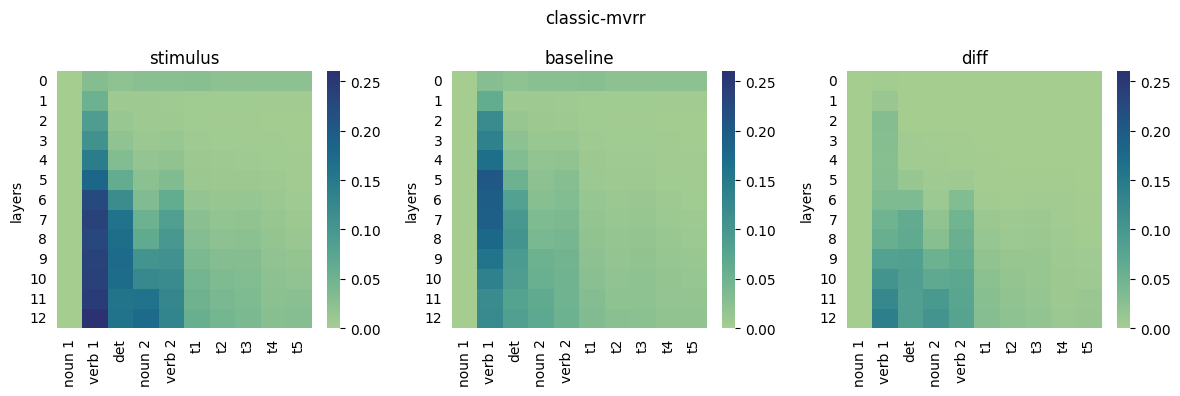

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
vmax = 0.1 if MODEL == 'gpt2' else 0.26

for chart, ax, title in zip ((mean_df.T, mean_df_ref.T, diff_df.T), axs, ('stimulus', 'baseline', 'diff')):
    sns.heatmap(chart,
                cmap='crest',
                ax=ax, 
                vmin=-0., vmax=vmax,
                #annot=True, fmt='.2f'
                )

    ax.tick_params(left=False, bottom=False)
    ax.set_ylabel('layers')
    ax.tick_params(axis='y', labelrotation=0)
    ax.set_title(title)

fig.suptitle(SOURCE)
plt.tight_layout()
plt.show()

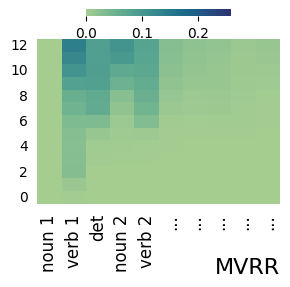

In [9]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.heatmap(diff_df.T.iloc[::-1],
            xticklabels=COLS[:5] + ['...', '...', '...', '...', '...'],
            cmap='crest',
            ax=ax, 
            vmin=-0., vmax=vmax,
            #annot=True, fmt='.2f'
            cbar_kws={'shrink': 0.6, "orientation": "horizontal", "anchor": (0.5, 9.2)},
            )

ax.tick_params(left=False, bottom=False)
#ax.set_ylabel('layers', fontsize=12)
ax.xaxis.set_tick_params(labelsize=12)
ax.tick_params(axis='y', labelrotation=0, labelsize=10)
plt.xlabel(SOURCE.split('-')[1].upper().replace('PS', 'P/S'), fontsize=16, loc='right', labelpad=-10)

plt.tight_layout()
plt.savefig(f'./figures/{SOURCE}_diff_{MODEL}_{METRIC}.pdf', bbox_inches='tight')
plt.show()

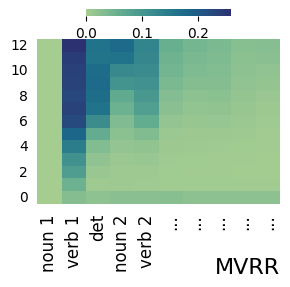

In [10]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.heatmap(mean_df.T.iloc[::-1],
            xticklabels=COLS[:5] + ['...', '...', '...', '...', '...'],
            cmap='crest',
            ax=ax, 
            vmin=-0., vmax=vmax,
            #annot=True, fmt='.2f'
            cbar_kws={'shrink': 0.6, "orientation": "horizontal", "anchor": (0.5, 9.2)},
            )

ax.tick_params(left=False, bottom=False)
#ax.set_ylabel('layers', fontsize=12)
ax.xaxis.set_tick_params(labelsize=12)
ax.tick_params(axis='y', labelrotation=0, labelsize=10)
plt.xlabel(SOURCE.split('-')[1].upper().replace('PS', 'P/S'), fontsize=16, loc='right', labelpad=-10)

plt.tight_layout()
plt.savefig(f'./figures/{SOURCE}_dists_{MODEL}_{METRIC}.pdf', bbox_inches='tight')
plt.show()